<a href="https://colab.research.google.com/github/YYIPL/ML_Project/blob/main/Projet_miniVQA_YIAY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Projet :

Vous devez créer un pipeline d'apprentissage automatique, basé sur les réseau de neurones, sur la tâche Visual Question Answering (VQA). Ceci comprend:*
- Creation d'un modèle
- Creation d'un dataloader
- Entraînement selon les splits
- Test sur le split de test
- Ecriture d'un rapport Scientifique

**Creation d'un modèle**

Les images sont de tailles 124x124. Les modèles classiques proposés par pytorch prennent en entrée des images de taille 224x224. <br/>
Nous voulons un modèle qui prennent en entrée les images de tailles 112x112.

Ce modèle encode l'image avec un CNN, et intègre la question dans le pipeline.

**Creation d'un dataloader**
  - sentence embedding (lente forward pass, il est judicieux de calculer cette représentation que une fois sachant que le modèle est pré-entrainé (et fixé).
  - il faut passer d'image 124x124 en 112x112, ceci permet de faire de la data-augmentation (randomresizecrop, randomflip, ...)
  - Le data loader retourne, au moins, la question, l'image et le label

**Entraînement selon les splits**

Il faut créer une procédure d'entrainement et selectionner votre meilleur modèle. Vous aurez surement besoin des methodes torch.save et torch.load pour gérer la sauvegarde de vos modèles.

Pour plus de facilités, vous pouvez directement connecter votre google drive a votre colab.
https://colab.research.google.com/notebooks/io.ipynb

Il y a plein de manières d'améliorer votre entrainement, voici quelques pistes :
  - crop dataloader (image augmentation)
  - dropout
  - Model ensembling
  - Lr scheduler
  - Early stop


 **Pas permis:**<br/>
 - Scale l'image en 224x224 et utiliser un réseau préentrainé


**Ne pas oublier**
- net.train(), net.eval() ne calcule pas les gradients et le dropout

**PS:**
Utiliser adam optimizer comme pour la scéance CNN.

**Test sur le split de test**:
Pour la compétition, il faut reporter la réponse choisie par le modèle (argmax) (cf sample_submission.csv).<br/>
Pour le rapport, il faut reporter l'accuracy top-1 (donnée par le argmax, i.e. cette réponse est elle la bonne réponse) et l'accuracy top-5 (la bonne réponse se trouve-elle dans les 5 plus grandes confiances données par votre modèle? )

**Ecriture d'un rapport Scientifique**

Au minimum, expliquer les points ci-dessus.

**Cela *peut* comprendre**:
- Explorez le jeu de données, donnez des exemples pour quelques classes, la distribution des labels (sous forme de graph ?)
- Quand vous prenez une decision (par exemple, data augementation), montrez visuellement l'effet de cette décision
- Expliquez votre réseau, que sont des convolution et du pooling, mettez des figures, expliquez votre stratégie pour définir la taille des filtres, etc..
- Montrez l'évolution de vos résultats par epoch (sous forme de graph ?), plottez l'accuracy, et la loss. Quelle stratégie d'apprentissage utilisez vous (lr scheduler, early stop, ...)
- Si vous utilisez du dropout, model ensembling, autre technique : explication et effet de cette technique, ...
- **PS: on a surement pas le temps de tout faire ! Concentrez vous sur certains points, et montrez leur impact (qu'il soit négatif ou positif, c'est ca la science...)**

In [2]:
!file=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX && wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='${file} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="${file} -O images.zip && rm -rf /tmp/cookies.txt \
&& unzip -qq images.zip && \
git clone https://github.com/jbdel/miniVQA

--2020-11-19 11:08:25--  https://docs.google.com/uc?export=download&confirm=Virl&id=1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX
Resolving docs.google.com (docs.google.com)... 172.217.204.101, 172.217.204.113, 172.217.204.139, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-2s-docs.googleusercontent.com/docs/securesc/kfa5k1uqo5b1qc4sd690otui16guklh2/rlljpd3399dr1gfhchupbjc6la0n730i/1605784050000/06540366866019348016/01384381893858658696Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download [following]
--2020-11-19 11:08:25--  https://doc-14-2s-docs.googleusercontent.com/docs/securesc/kfa5k1uqo5b1qc4sd690otui16guklh2/rlljpd3399dr1gfhchupbjc6la0n730i/1605784050000/06540366866019348016/01384381893858658696Z/1pfd5-i_F20zViKIYwbQ8jL1p78s_E6uX?e=download
Resolving doc-14-2s-docs.googleusercontent.com (doc-14-2s-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Conne

In [3]:
!ls && ls -d miniVQA/*

image124  images.zip  miniVQA  sample_data
miniVQA/answer_list.txt      miniVQA/sample_submission.csv  miniVQA/val.csv
miniVQA/image_question.json  miniVQA/test.csv
miniVQA/README.md	     miniVQA/train.csv


## **Overview dataset**

In [4]:
!wc -l miniVQA/*.csv

  6288 miniVQA/sample_submission.csv
  6288 miniVQA/test.csv
 50300 miniVQA/train.csv
  6300 miniVQA/val.csv
 69176 total


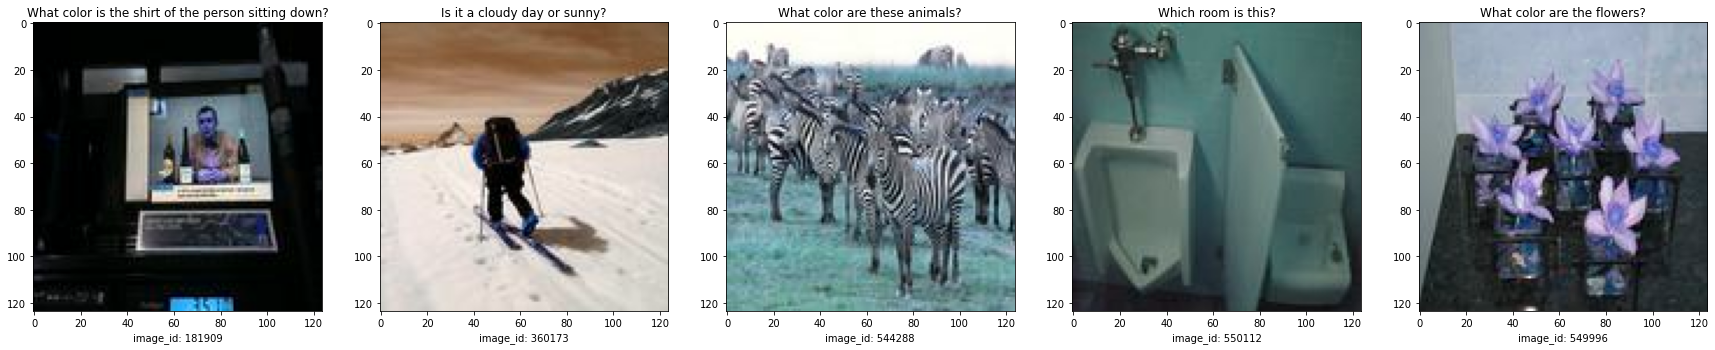

In [5]:
import json
import random
import matplotlib.pyplot as plt
import cv2

image_question = json.load(open('miniVQA/image_question.json'))
plt.figure(figsize=([30, 20]))

for i in range(5):
  plt.subplot(1, 5, i+1)
  random_image = random.choice(list(image_question.keys()))
  _, random_question = random.choice(image_question[random_image])
  plt.imshow(cv2.resize(cv2.imread('image124/'+random_image+'.jpg'), (124,124)))
  plt.xlabel('image_id: '+random_image)
  plt.title(random_question)

## **Sentence Embedding**

In [6]:
!pip install sentence_transformers

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 1.3MB 4.5MB/s 
     |████████████████████████████████| 2.9MB 14.9MB/s 
     |████████████████████████████████| 1.1MB 37.8MB/s 
     |████████████████████████████████| 890kB 36.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101036 sha256=814eaafc50d0276c7220e332a68e84ccc4d8bbc1e663546b7060e288ae9c839b
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=125d7cae41285685443b9442fdd25921fb1ef9588012086562fa53d6cccd382e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [7]:
from sentence_transformers import SentenceTransformer
import time

model = SentenceTransformer('distilbert-base-nli-mean-tokens').cuda() # ne pas toucher

sentences = 'This framework generates embeddings for each input sentence word hello ok'
time_start = time.time()
sentence_embeddings = model.encode(sentences)
print(time.time()-time_start)
print(sentence_embeddings.shape)


100%|██████████| 245M/245M [00:15<00:00, 15.3MB/s]


RuntimeError: ignored

## **Creation d'un dataloader**

In [ ]:
import pandas as pd
import csv

questionsIdImages = dict()
questionsIdQuestions = dict()
questionsEmbedded = dict()

for i in image_question.keys():
  for j in image_question[i]:
    questionId = str(j[0])
    image = str(i)
    questionsIdImages[questionId] = image
    question = str(j[1])
    questionsIdQuestions[questionId] = question
    if question not in questionsEmbedded.keys():
      questionsEmbedded[question] = model.encode(question)



In [ ]:
from torchvision.transforms import *
import torch
from torch.nn import *
import torch.nn as nn

from PIL import Image
import numpy as np
import torch.nn.functional as F

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, split, random=False):
        assert split in ["train","val","test"]
        self.split = split
        self.image_dir = "image124/"
        self.file = f"miniVQA/{split}.csv"

        self.images = []
        self.questions = []
        self.questionsId = []
        self.labels = []

        with open(self.file,encoding='utf-8-sig') as csvfile:
          csv_reader = csv.reader(csvfile)
          next(csv_reader)
          for line in csv_reader:
            questionId = line[0]
            question = questionsEmbedded.get(questionsIdQuestions.get(questionId))

            self.images.append(f"{questionsIdImages.get(questionId)}.jpg")
            self.questions.append(question)
            self.questionsId.append(questionId)

            if split != "test":
              label = line[1]
              self.labels.append(label)

        if random:
          self.transform = Compose([RandomResizedCrop((112, 112)),
                                    RandomRotation((0,359)),
                                    RandomHorizontalFlip(p=0.5),
                                    RandomVerticalFlip(p=0.5) ,
                                    ToTensor()]) 
        else : 
          self.transform = Compose([Resize((112, 112)), ToTensor()])
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images)

  def __getitem__(self, index):
        'Generates one sample of data'
    
        img_path = self.image_dir + self.images[index]
        img = Image.open(img_path).convert('RGB')

        img = self.transform(img)
        label = 0

        if not self.split == "test":
          label = self.labels[index]
          
        label = np.array(label, dtype=np.int64)
        question = np.array(self.questions[index])
        questionId = np.array(self.questionsId[index], dtype=np.int64)
        return img, question, questionId, label

## **Creation d'un modèle**

In [ ]:
class Network(nn.Module):
    def __init__(self, num_classes=None):
        super(Network, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=11,stride=4 ,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2 ),
            nn.Conv2d(in_channels=64,out_channels=192,kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.Conv2d(in_channels=192,out_channels=384,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=384,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=13312, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes, bias=True),
        )

        self.adaptive = AdaptiveAvgPool2d(output_size=6) 

    def forward(self, x: torch.Tensor, question):
        # A compléter
        # Appelez self.features
        # puis aplatissez avec flatten()
        # puis appelez self.classifier
        x = self.features(x)
        x=  self.adaptive(x)
        x = torch.flatten(x,1) 
        x = torch.cat((x, question),dim=1)  
        x = self.classifier(x)
        return x

In [ ]:
train_dataset = Dataset(split="train",random=True)
train_accuracy_dataset = Dataset(split="train")
val_dataset = Dataset(split="val")
test_dataset = Dataset(split="test")

training_generator = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
training_accuracy_generator = torch.utils.data.DataLoader(train_accuracy_dataset, batch_size=64, shuffle=True)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(net, batch_size=32, learning_rate=1e-3, num_epochs=1):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-2, max_lr=1e-5,step_size_up=10,mode="triangular", verbose=True) #Learning rate scheduler https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
    accuracy_train_epoch = []
    accuracy_val_epoch = []
    
    for i in range(1, num_epochs + 1):  
      net.train() # nouveau
      for j, sample in enumerate(training_generator):
        x, question, _, y = sample 
        optimizer.zero_grad()
        out = net(x.cuda(), question.cuda())
        loss = loss_func(out, y.cuda())
        loss.backward()
        optimizer.step()
        print('\r Epoch', i, 'Step', j , ':' , str(loss.data.cpu().numpy()), end="")
      net.eval() # nouveau


      accuracy = []
      for j,sample in enumerate(training_accuracy_generator):
        x, question, _, y = sample
        out = net(x.cuda(),question.cuda())
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.append(np.mean(best == y.data.cpu().numpy()))

      accuracy_train_epoch.append(np.mean(accuracy) * 100)

      #scheduler.step()
    
      accuracy = []
      for j, sample in enumerate(val_generator):
        x, question, _, y = sample
        out = net(x.cuda(),question.cuda())
        best = np.argmax(out.data.cpu().numpy(), axis=-1)
        accuracy.append(np.mean(best == y.data.cpu().numpy()))

      accuracy_val_epoch.append(np.mean(accuracy) * 100)

    plt.figure(figsize=(12,8))
    plt.plot(list(range(1,num_epochs + 1)),accuracy_train_epoch, label='train')
    plt.plot(list(range(1,num_epochs + 1)),accuracy_val_epoch, label='val')
    plt.legend()
    plt.show()
    print("done")



## **RESNET**

In [ ]:
import torch.nn as nn

class block(nn.Module):
  def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
    super(block, self).__init__()
    self.expansion = 4
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
    self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
  
  def forward(self, x):
    identity = x
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
      identity = self.identity_downsample(identity)
    
    x += identity
    x = self.relu(x)
    return x

class ResNet(nn.Module):
  def __init__(self, block, layers, image_channels, num_classes):
    super(ResNet, self).__init__()
    self.expansion = 4
    self.in_channels = 64
    self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride = 2)
    self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride = 2)
    self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride = 2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * self.expansion + 768, num_classes)

  def forward(self, x, question):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    
    x = torch.flatten(x,1)
    x = torch.cat((x,question), dim=1)

    x = self.fc(x)

    return x


  def _make_layer(self, block, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * self.expansion:
      identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels * self.expansion, kernel_size=1, stride=stride),
                                          nn.BatchNorm2d(out_channels * self.expansion)
                                          )
      
    layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
    self.in_channels = out_channels * self.expansion

    for i in range(num_residual_blocks - 1):
      layers.append(block(self.in_channels, out_channels))

    return nn.Sequential(*layers) 

In [ ]:
def ResNet50(img_channels=3, num_classes=100):
  return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

In [ ]:
# resnet = ResNet50()
# train(resnet.cuda() , num_epochs=10)

## **MODEL ENSEMBLING**

 Epoch 100 Step 785 : 2.2053003

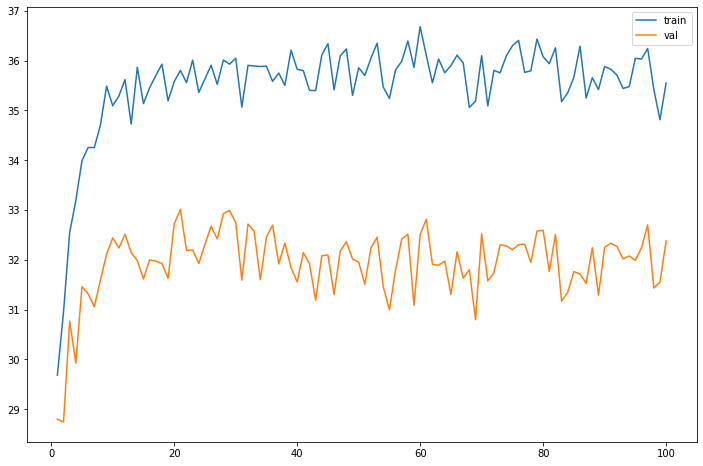

done


In [ ]:
net = Network(100)
net.cuda()
train(net,num_epochs=50)

In [ ]:
net2 = Network(100)
net2.cuda()
train(net2,num_epochs=1)

 Epoch 1 Step 15 : 4.2909455

KeyboardInterrupt: ignored

In [ ]:
net3 = Network(100)
net3.cuda()
train(net3,num_epochs=1)

In [ ]:
net4 = Network(100)
net4.cuda()
train(net4,num_epochs=2)

In [ ]:
net5 = Network(100)
net5.cuda()
train(net5,num_epochs=2)

In [ ]:
outexample1 = []
outexample2 = []
class ModelEnsemble(nn.Module):

    def __init__(self, modelA, modelB,input):
        super(ModelEnsemble, self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        #self.modelC = modelC
        #self.modelD = modelD
        #self.modelE = modelE
        self.fc1 = nn.Linear(100, 100)

    def forward(self, x,y):
        out1 = self.modelA(x,y)
        out2 = self.modelB(x,y)
        #out3 = self.modelC(x,y)
        #out4 = self.modelD(x)
        #out5 = self.modelE(x)
        batch = []
        l,m = out1.shape
        for i in range(l):
          np1 = out1[i].data.cpu().numpy()
          np2 = out2[i].data.cpu().numpy()
          tabNP = np.array([np1,np2])
          batch.append(np.mean(tabNP,axis=0))
        out = torch.tensor(batch)
        return out

In [ ]:
ensemble = ModelEnsemble(net,net2,100)
ensemble.cuda()
print()

In [ ]:
ensemble.eval() # nouveau
accuracy = []
for j, sample in enumerate(val_generator):
  x, question, _, y = sample
  out = ensemble(x.cuda(),question.cuda())
  best = np.argmax(out.data.cpu().numpy(), axis=-1)
  accuracy.extend(list(best == y.data.cpu().numpy()))
print('\n Accuracy is ' , str(np.mean(accuracy)*100))

## **Test**

In [ ]:
answers = []
questionsId = []

for j, sample in enumerate(test_generator):
  x, question, questionId, _ = sample 
  questionId = questionId.cpu().numpy()[0]
  out = net(x.cuda(), question.cuda())

  out_numpy = out.data.cpu().numpy()
  answers.append(np.argmax(out_numpy, axis=1))
  questionsId.append(questionId)

with open('sample_submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["id", "label"])
    for i in range(len(answers)):
      writer.writerow([questionsId[i], answers[i][0]])